Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from: /content/drive/MyDrive/wifi_csi_har_dataset/room_1/1
Data loaded successfully. Shape of X: (5230, 1026), Shape of y: (5229,)
Adjusted data shapes - X: (5229, 1026), y: (5229,)
Epoch 1/50
105/105 [==============================] - 6s 19ms/step - loss: 1.6742 - accuracy: 0.4680 - val_loss: 1.6046 - val_accuracy: 0.4851
Epoch 2/50
105/105 [==============================] - 1s 11ms/step - loss: 1.6241 - accuracy: 0.4683 - val_loss: 1.6057 - val_accuracy: 0.4851
Epoch 3/50
105/105 [==============================] - 1s 10ms/step - loss: 1.6245 - accuracy: 0.4683 - val_loss: 1.6032 - val_accuracy: 0.4851
Epoch 4/50
105/105 [==============================] - 1s 14ms/step - loss: 1.6226 - accuracy: 0.4683 - val_loss: 1.6031 - val_accuracy: 0.4851
Epoch 5/50
105/105 [==============================] - 2s 15ms/step - loss: 1.6231 - accuracy: 0.4683 - v

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


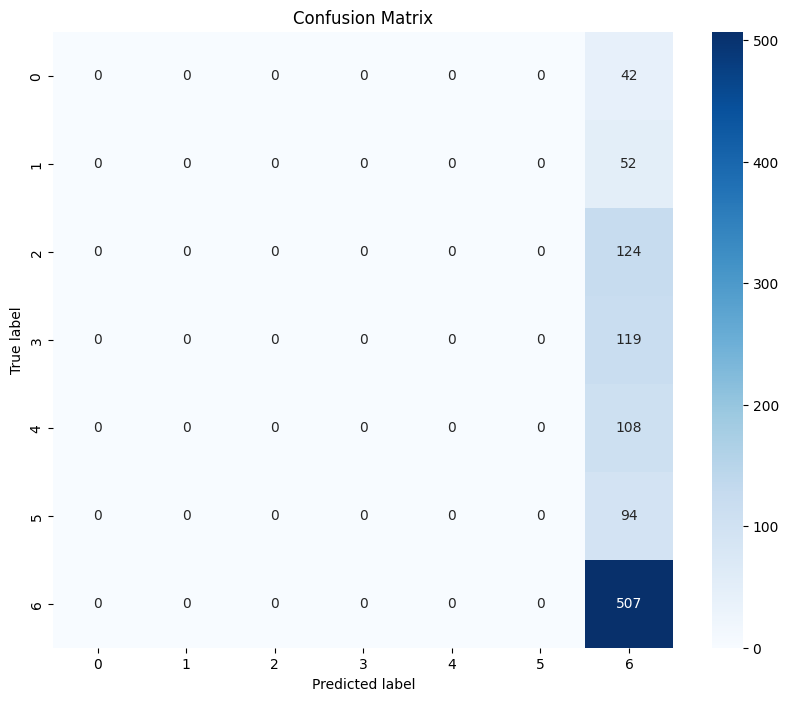

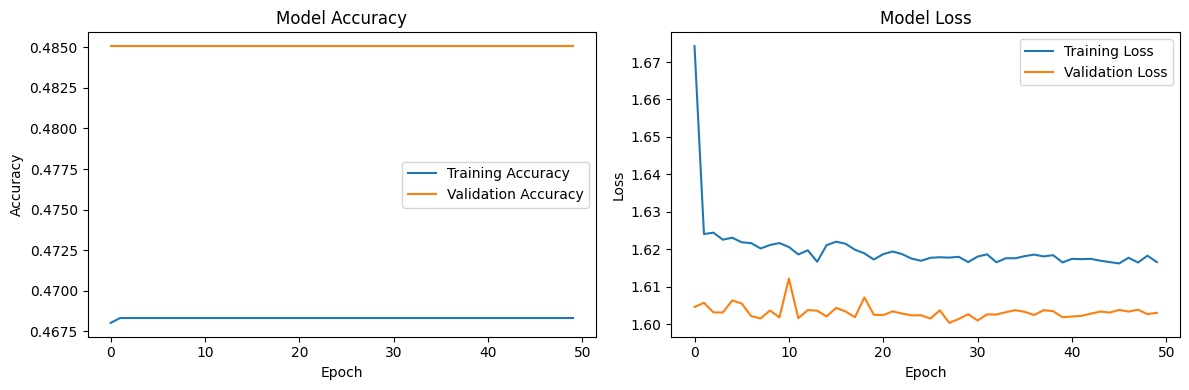

Unique activities: ['get_down' 'get_up' 'lying' 'no_person' 'sitting' 'standing' 'walking']


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your dataset
base_path = '/content/drive/MyDrive/wifi_csi_har_dataset/room_1/1'

def load_data(base_path):
    print(f"Loading data from: {base_path}")

    data_file = os.path.join(base_path, 'data.csv')
    label_file = os.path.join(base_path, 'label.csv')

    if not os.path.exists(data_file) or not os.path.exists(label_file):
        raise ValueError(f"Data or label file not found in: {base_path}")

    # Load CSI data
    csi_data = pd.read_csv(data_file, header=None).values

    # Load labels
    labels = pd.read_csv(label_file, header=None)[1].values

    print(f"Data loaded successfully. Shape of X: {csi_data.shape}, Shape of y: {labels.shape}")

    return csi_data, labels

# Load and preprocess the data
try:
    X, y = load_data(base_path)
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

# Handle the mismatch in sample numbers
min_samples = min(X.shape[0], y.shape[0])
X = X[:min_samples]
y = y[:min_samples]

print(f"Adjusted data shapes - X: {X.shape}, y: {y.shape}")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to categorical
y_categorical = to_categorical(y_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
cm = confusion_matrix(y_true, y_pred_classes)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print unique activities
print("Unique activities:", le.classes_)

----

Applying some preprocessing and feature extraction techniques to the raw CSI data could significantly improve the results. Let's modify our approach to include Principal Component Analysis (PCA) for dimensionality reduction and feature extraction.

Key changes in this updated script:

1. I've added StandardScaler to normalize the input features before applying PCA.
2. PCA is applied to reduce the dimensionality of the data to 100 components. You can adjust this number based on the explained variance ratio.
3. The LSTM model architecture has been slightly modified to accommodate the new input shape and potentially capture more complex patterns.
4. The number of epochs has been increased to 100 to allow for more training time.

This approach should help in the following ways:

1. Dimensionality Reduction: PCA will reduce the number of features, potentially removing noise and making the learning task easier for the model.
2. Feature Extraction: PCA will create new features that are linear combinations of the original features, potentially capturing more meaningful information.
3. Computational Efficiency: With fewer features, the model will train faster and require less memory.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from: /content/drive/MyDrive/wifi_csi_har_dataset/room_1/1
Data loaded successfully. Shape of X: (5230, 1026), Shape of y: (5229,)
Adjusted data shapes - X: (5229, 1026), y: (5229,)
Shape after PCA: (5229, 100)
Explained variance ratio: 0.9797
Epoch 1/100
105/105 [==============================] - 9s 30ms/step - loss: 1.5122 - accuracy: 0.5099 - val_loss: 1.0677 - val_accuracy: 0.6595
Epoch 2/100
105/105 [==============================] - 2s 15ms/step - loss: 0.8831 - accuracy: 0.6820 - val_loss: 0.7186 - val_accuracy: 0.7455
Epoch 3/100
105/105 [==============================] - 2s 17ms/step - loss: 0.6337 - accuracy: 0.7785 - val_loss: 0.5607 - val_accuracy: 0.8065
Epoch 4/100
105/105 [==============================] - 3s 24ms/step - loss: 0.4773 - accuracy: 0.8237 - val_loss: 0.4757 - val_accuracy: 0.8339
Epoch 5/100
105/105 [=================

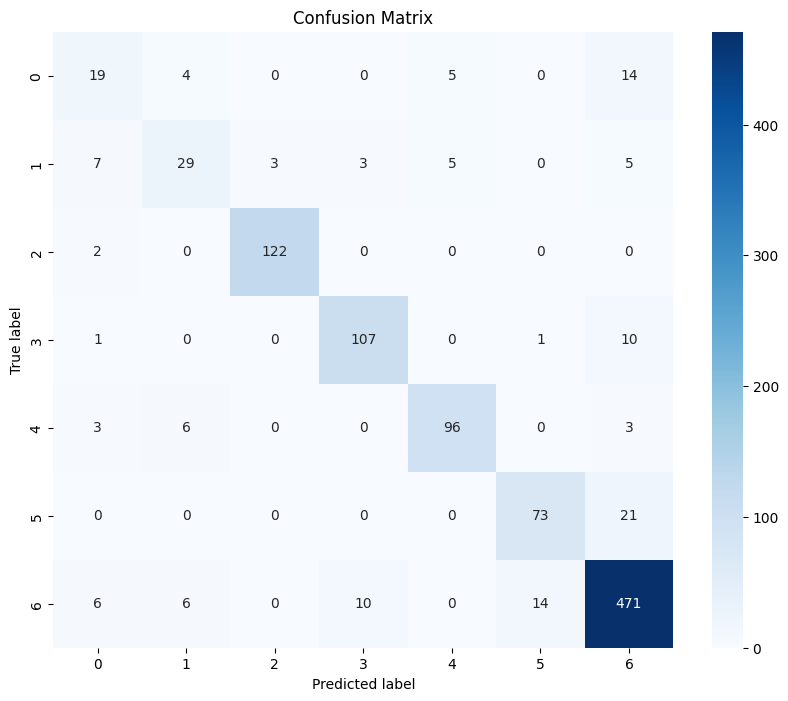

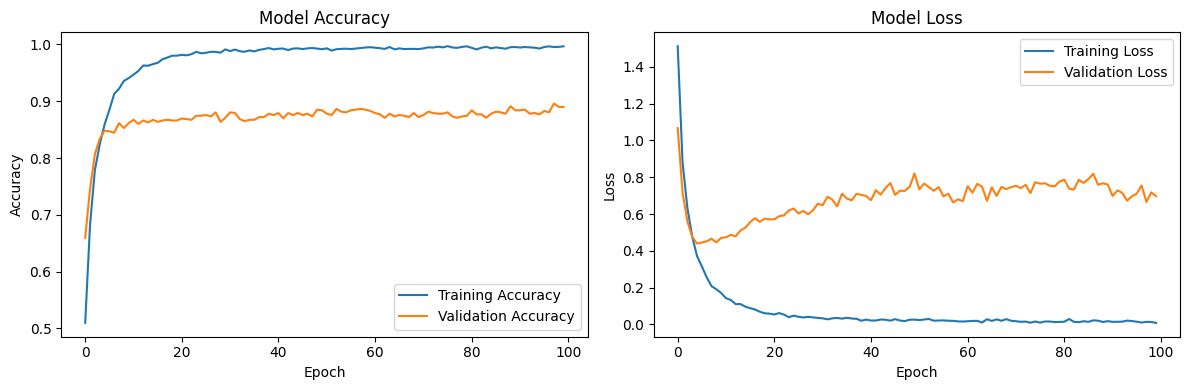

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your dataset
base_path = '/content/drive/MyDrive/wifi_csi_har_dataset/room_1/1'

def load_data(base_path):
    print(f"Loading data from: {base_path}")

    data_file = os.path.join(base_path, 'data.csv')
    label_file = os.path.join(base_path, 'label.csv')

    if not os.path.exists(data_file) or not os.path.exists(label_file):
        raise ValueError(f"Data or label file not found in: {base_path}")

    # Load CSI data
    csi_data = pd.read_csv(data_file, header=None).values

    # Load labels
    labels = pd.read_csv(label_file, header=None)[1].values

    print(f"Data loaded successfully. Shape of X: {csi_data.shape}, Shape of y: {labels.shape}")

    return csi_data, labels

# Load and preprocess the data
X, y = load_data(base_path)

# Handle the mismatch in sample numbers
min_samples = min(X.shape[0], y.shape[0])
X = X[:min_samples]
y = y[:min_samples]

print(f"Adjusted data shapes - X: {X.shape}, y: {y.shape}")

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
n_components = 100  # You can adjust this number
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"Shape after PCA: {X_pca.shape}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to categorical
y_categorical = to_categorical(y_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_categorical, test_size=0.2, random_state=42)

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential([
    LSTM(128, input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
cm = confusion_matrix(y_true, y_pred_classes)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print unique activities
print("Unique activities:", le.classes_)

---